In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
from src.visualization.visualize import make_fig

# Loading the data

Dataset is taken from here: https://www.kaggle.com/datasets/erak1006/brazilian-e-commerce-company-olist  
It contains 9 tables but only 3 of them are used in this project.

In [3]:
dict_raw_data = {}

def load_raw_data(name):
    path = f'../data/raw/OLIST/{name}.csv'
    dict_raw_data[name] = pd.read_csv(path)
    print(f'Loaded {name} with {dict_raw_data[name].shape[0]} rows and {dict_raw_data[name].shape[1]} columns.')
    return dict_raw_data[name].head(3)


for name in ['orders_dataset',
             'order_items_dataset',
             'products_dataset']:
    display(load_raw_data(name))

df_raw_order_items = dict_raw_data['order_items_dataset']
df_raw_products = dict_raw_data['products_dataset']
df_raw_orders = dict_raw_data['orders_dataset']

Loaded orders_dataset with 99441 rows and 8 columns.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Loaded order_items_dataset with 112650 rows and 7 columns.


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


Loaded products_dataset with 32951 rows and 9 columns.


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


# Deciding on the required schema for the data
Tables above contain the data about individual orders, items within these orders and product categories of these items.

We are going to predict the products sales. In order to do so, we need to decide on the time granularity since we can combine orders by any time period we need. 
Depending on the business needs it might be daily, weekly, montly or some other time step. Larger the time step we use, the less noise we have in the data. With smaller time step we have more data points. Daily or weekly seem to be the most feasible options for the purpose of this project.  
Let's use the daily granularity.

# Transforming the data
Every order contains items. We are not interested in the individual orders, but in the items that are actually sold - their categories and quantities. Therefore order_items table is joined with the products table to get the category names. And then joined with orders table to get the order date.

In [4]:
df_order_items = df_raw_order_items.merge(
    df_raw_products[['product_id', 'product_category_name']],
    on='product_id', how='left')
df_order_items = df_order_items.merge(
    df_raw_orders[['order_id', 'order_purchase_timestamp', 'order_status']],
    on='order_id', how='left')
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_purchase_timestamp,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,2017-09-13 08:59:02,delivered
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,2017-04-26 10:53:06,delivered
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,2018-01-14 14:33:31,delivered
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,2018-08-08 10:00:35,delivered
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,2017-02-04 13:57:51,delivered


Details such as shipping limit date or order id are irrelevant for our purposes. These and few other columns are dropped. Order status might be important though.

In [5]:
df_order_products = df_order_items.drop(
    columns=['order_id', 'order_item_id', 'seller_id', 'shipping_limit_date', 'freight_value'])

df_order_products.head()

,product_id,price,product_category_name,order_purchase_timestamp,order_status
0,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,delivered
1,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,delivered
2,c777355d18b72b67abbeef9df44fd0fd,199.00,moveis_decoracao,2018-01-14 14:33:31,delivered
3,7634da152a4610f1595efa32f14722fc,12.99,perfumaria,2018-08-08 10:00:35,delivered
4,ac6c3623068f30de03045865e4e10089,199.90,ferramentas_jardim,2017-02-04 13:57:51,delivered


Lets check the possible order_status values and their counts.

In [6]:
df_order_products['order_status'].value_counts()

order_status
delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: count, dtype: int64

Some **assumptions** must be made at this point:
* 'delivered' and 'shipped' statuses represent the succesfull sales
* the rest of the statuses are considered not succesfull sales

Based on these assumptions, we are going to only use the 'delivered' and 'shipped' orders.

In [7]:
df_order_products_filtered = df_order_products[
    df_order_products['order_status'].isin(['delivered', 'shipped'])
].copy()

# converting the order_purchase_timestamp to datetime
df_order_products_filtered['order_purchase_timestamp'] = pd.to_datetime(df_order_products_filtered['order_purchase_timestamp'])

# creating a new column with the date of the order
df_order_products_filtered.loc[:,'order_date'] = df_order_products_filtered['order_purchase_timestamp'].dt.floor('D')

df_order_products_filtered.head()

,product_id,price,product_category_name,order_purchase_timestamp,order_status,order_date
0,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,delivered,2017-09-13
1,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,delivered,2017-04-26
2,c777355d18b72b67abbeef9df44fd0fd,199.00,moveis_decoracao,2018-01-14 14:33:31,delivered,2018-01-14
3,7634da152a4610f1595efa32f14722fc,12.99,perfumaria,2018-08-08 10:00:35,delivered,2018-08-08
4,ac6c3623068f30de03045865e4e10089,199.90,ferramentas_jardim,2017-02-04 13:57:51,delivered,2017-02-04


Now we can aggregate the data and calculate the number of items sold per product category per day.

In [8]:
df_order_products_agg =  df_order_products_filtered.groupby(
    ['product_category_name','order_date']
    ).agg({'product_id': 'count'}).rename(columns={'product_id': 'items_sold'}).reset_index()
df_order_products_agg.head()

,product_category_name,order_date,items_sold
0,agro_industria_e_comercio,2017-01-23,2
1,agro_industria_e_comercio,2017-01-31,1
2,agro_industria_e_comercio,2017-02-05,1
3,agro_industria_e_comercio,2017-02-08,1
4,agro_industria_e_comercio,2017-02-12,1


# Examining the transformed data, selecting the data for forecasting

Data might have the gaps. Visualisation would help to reveal them.

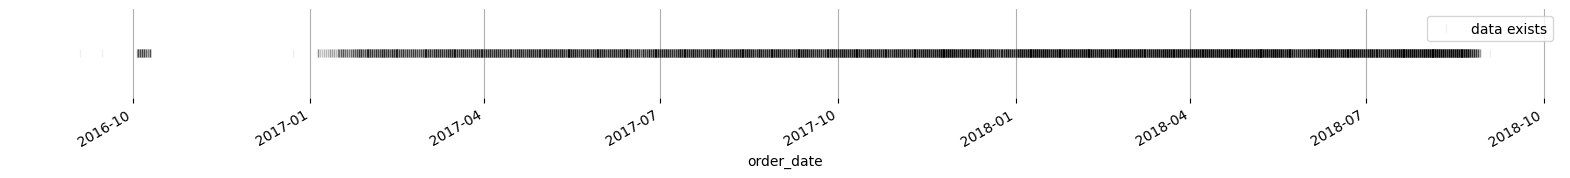

In [9]:
fig, ax = make_fig(20, 1.3)
df_date_availability = df_order_products_agg['order_date'].to_frame()
df_date_availability['data exists'] = 1
df_date_availability.set_index('order_date', inplace=True)
df_date_availability.plot(marker='|', linewidth=0., color='#00000010', ax=ax)
ax.set_yticks([])
ax.grid(axis='x')

Indeed there is a large gap at the beginning of the dataset. There is also one or few isolated data points at the very end. We should keep in mind that this daily data was generated based on the individual orders. So we can't tell for sure whether these gaps represent the data issues or genuine lack of orders. And if it's the lack of orders, was it caused by the lack of consumers or by the fact that store was closed.  
  
Since we don't have the additional information about this dataset or a way to get it, we will have to make additional assumptions. But first lets explore these gaps in more details by looking at the actual number of orders.

Pivotting the table so that we have separate column per product category. Filling missing values with zeroes (since there were no orders for such category+date combination) and adding the missing dates.

In [10]:
df_product_sales = df_order_products_agg.pivot(index='order_date', columns='product_category_name', values='items_sold')
df_product_sales = df_product_sales.fillna(0)
df_product_sales = df_product_sales.resample('D').sum()
df_product_sales.head()

product_category_name,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,...,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas
order_date,,,,,,,,,,,,,,,,,,,,,
2016-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can show the number of sales timeline for each product category.

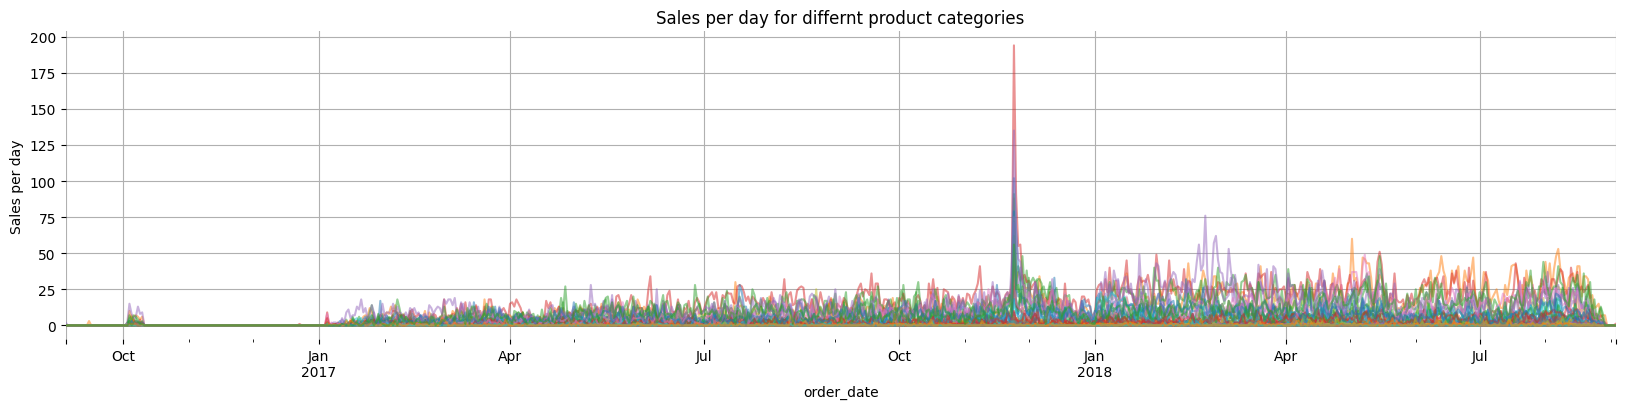

In [11]:
def plot_sales(df_product_sales, show_legend=False, fig_size=(20,4)):
    fig, ax = make_fig(*fig_size)
    df_product_sales.plot(ax=ax, legend=False, alpha=0.5)
    ax.set_ylabel('Sales per day')
    if show_legend:
        ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.grid()
    ax.set_title('Sales per day for differnt product categories')
    plt.show()

plot_sales(df_product_sales)

There seems to be an overall growing trend that is interrupted by a large ~3 months gap of almost zero orders at the end of 2016. And it happens to be at the beginning of the dataset. 
   
Also at the very end of the dataset orders quickly drop to almost zero. Of course this might be a genuine drop but it seems unlikely considering it's at the very end of the dataset. It looks like it might be caused by the data gathering delay i.e. very recent orders didn't actually made it to the database. There is no way to tell for sure so we have to make **additional assumptions** about the data availability here.
* We only keep data between Feb 2017 and Aug 2018.

In [12]:
df_product_sales_trimmed = df_product_sales[
    (df_product_sales.index >= datetime(2017, 2, 1)) &\
    (df_product_sales.index < datetime(2018, 8, 1))
]

Also, we are not going to forecast the sales of all product categories. We are going to forecast the sales of the top 1 product category.

In [18]:
df_top_product = df_product_sales_trimmed.sum().sort_values(ascending=False).head(1)
df_top_product

product_category_name
cama_mesa_banho    10359.0
dtype: float64

This is our final dataset that we are going to use for forecasting:

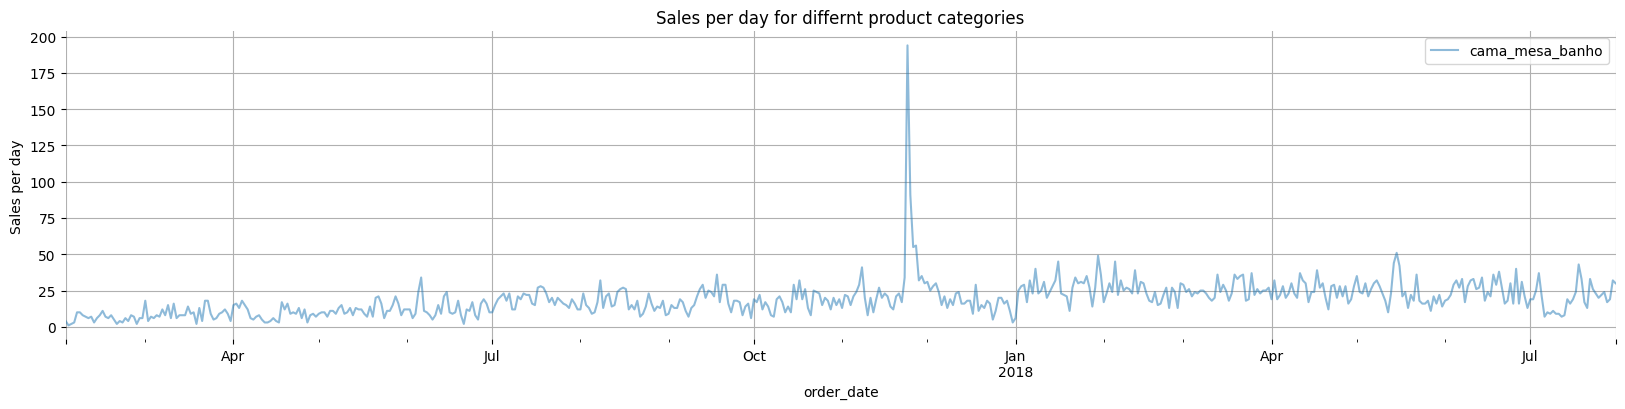

product_category_name,cama_mesa_banho
order_date,
2017-02-01,4.0
2017-02-02,1.0
2017-02-03,2.0
2017-02-04,3.0
2017-02-05,10.0


In [19]:
df_product_sales_trimmed_top = df_product_sales_trimmed[df_top_product.index]
plot_sales(df_product_sales_trimmed_top, show_legend=True)
df_product_sales_trimmed_top.head()

**NOTE**: The code from this notebook will be used as a basis for the data processing stage. While we can refactor the notebook and retrospectively replace the data transformation code above with the one extracted into src/data folder, it was deliberately decided to leave it here intact (and therefore creating some code duplication) in order to represent the thinking process during the data exloration stage.